In [2]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
from scipy.stats import wishart

In [3]:
from ott.tools.gaussian_mixture import gaussian_mixture
from ott.core import segment, bar_problems
from ott.core import continuous_barycenter
from ott.geometry import costs

In this notebook we demonstrate how we can compute Wasserstein barycenters of mixtures of Gaussians.

# Generate the Gaussian Mixture Models.

First, we randomly generate the $d$ dimensional mixtures of Gaussians. 

For each GMM we chose an offset $c \in \mathbb{R}^d$ for the means of the components and a parameter $s\geq0$ that affects the covariance matrices of the components.

The means of the components of a GMM are generated as:

$$\mu = c + u,$$

where $u$ follows the uniform distribution $\mathcal{U}(0,|\bar{c}|)$ with $\bar{c}=\frac{1}{d} \sum_{i=1}^d c_i$. 

The covariances of the components of a GMM are generated as samples of the Wishart distribution $W_d(\nu, \Sigma)$, where $\nu$ is the degrees of freedom and $\Sigma \in \mathbb{R}^{d \times d}$ is the scale matrix. The scale matrix is generated as:

$$\Sigma=GG^{\top}+\lambda I,$$

where $G \in \mathbb{R}^{d \times d}$ is drawn from the Gaussian normal distribution. The identity matrix with weight $\lambda=10^{-3}$ is added in order to ensure that the scale matrix $\Sigma$ is [positive definite](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wishart.html).

The degrees of freedom $\nu$ must satisfy $\nu \geq d$. Therefore, $\nu$ is determined as $\nu = d + s$ with $s \geq 0$.

We generate three GMMs, each composed of a different number of components. 

In [4]:
dim = 2 # the dimension of the Gaussians
n_components = jnp.array([2, 3, 5]) # the number of components of the GMMs  
n_gmms = n_components.size # the number of GMMs whose barycenter will be computed
epsilon = 0.1 # the entropy regularization parameter 

In [5]:
# the maximal number of components of the considered GMMs
max_gmm_size = jnp.amax(n_components)

The barycentric weights determine how much each GMM will contribute to the Wasserstein barycenter computation. Since these weights must sum to one, we generate them by sampling Dirichlet random values. Larger values of the concentration parameter $\alpha$ lead to barycentric weights that are more uniform. Smaller values of $\alpha$ will result to certain GMMs contributing significantly more than others to the barycenter computation.   

In [6]:
# generate the pseudo-random keys that will be needed
key = jax.random.PRNGKey(seed=3)
keys = jax.random.split(key, num=n_gmms+2) 

In [7]:
alpha = 50. # the concentration parameter of Dirichlet

In [8]:
barycentric_weights = jax.random.dirichlet(keys[0], alpha=jnp.ones(n_gmms)*alpha) 

In [9]:
# Create the seeds for the random generation of each measure.
seeds = jax.random.randint(keys[1], shape=(n_gmms,), minval=0, maxval=100)

We set the offsets $c$ for each GMM to be different so that they can be easily visualized.

In [10]:
# Offsets for the means of each GMM
cs = jnp.array([[-20, -15], [60, -25], [50, 35]])

We select the parameter $s$ that will determine the degrees of freedom of the Wishart distribution considered for each GMM. 

In [11]:
# Parameter that controls the degrees of freedom of the Wishart distribution
ss = jnp.array([2, 3, 5])

In [12]:
assert cs.shape[0] == n_gmms
assert ss.size == n_gmms
assert seeds.size == n_gmms
assert n_components.size == n_gmms
assert jnp.array_equal(jnp.absolute(ss), ss)
assert jnp.mean(cs, axis=1).all() > 0

In [13]:
def generate_means_and_covs_for_random_gmm(num_components, dimension, c, s, rng=0):
    """
    Generate the means and covariance matrices of a random Gaussian Mixture Model.
    
    Args:
        num_components: The number of components of the Gaussian mixture model.
        dimension: The dimension of the Gaussian mixture model.
        c: Offset for the means of the GMM.
        s: Parameter controlling the degrees of freedom of the Wishart distribution for the covariance matrices.
        rng: The seed used for the pseudo-random generator.
    Returns:
        means: The means of the components.
        covs: The covariance matrices of the component.
    """
    s = jnp.atleast_1d(s)
    assert s >= 0 
    key = jax.random.PRNGKey(rng)
    keys = jax.random.split(key, num=3)
    means = c + jax.random.uniform(keys[0], shape=(num_components, dimension), minval=0, maxval=jnp.absolute(jnp.mean(c)))
    nu = s[0].tolist() + dimension # degree of freedom of Wishart distribution
    g_matrix = jax.random.normal(keys[1], (dimension, dimension))
    scale_matrix =  g_matrix @ jnp.transpose(g_matrix) + 1e-3 * jnp.eye(dimension)
    covs = jnp.array(wishart.rvs(df=nu, scale=scale_matrix, size=num_components, random_state=0))
    return means, covs

In [14]:
# generate the means and covariances of the GMMs
means_covs = [generate_means_and_covs_for_random_gmm(n_components[i], dim, cs[i], ss[i], seeds[i]) for i in range(n_gmms)]

In [15]:
# stack the concatenated means and (raveled) covariances of the pointclouds
ys = jnp.vstack((costs.means_and_covs_to_x(means_covs[i][0], means_covs[i][1], dim) for i in range(n_gmms)))

We generate the weights of the GMMs that will describe the significance of each Gaussian of a GMM by sampling Dirichlet random values. One can consider different $\alpha$ parameters of each GMM. Here, for simplicity, we use the same concentration parameter $\alpha$ for all GMMs.

In [16]:
weights = [jax.random.dirichlet(keys[i+2], alpha=jnp.ones(n_components[i])*alpha) for i in range(n_gmms)]

In [17]:
# stack the weights of the GMMs
bs = jnp.hstack(jnp.array(weights[i]) for i in range(n_gmms))

In [18]:
# segment the pointclouds of GMMs to enable parallelization of the OT problems with jax.vmap
segmented_y, segmented_b, num_segments = segment.segment_point_cloud(ys, num_per_segment=n_components, num_segments=n_gmms, custom_padder=costs.mean_and_cov_padder)

In [19]:
assert segmented_y.shape == (n_gmms, max_gmm_size, dim*(dim+1))
assert segmented_b.shape == (n_gmms, max_gmm_size)
assert num_segments == n_gmms

# Compute the Wasserstein barycenter of the GMMs.

We can now compute the barycenter of the input GMMs. We determine the number of components of the barycenter GMM and solve the barycenter problem. We must ensure that the initialization of the barycenter is valid, in the sense that the covariance matrix must be a positive semidefinite matrix. We therefore initialize the barycenter, using ``generate_means_and_covs_for_random_gmm()``.

In [20]:
# Determine the size of the barycenter.
bar_size = 6

In [21]:
# Initialize the means and the covariances of the GMM barycenter.
x_init_means, x_init_covs = generate_means_and_covs_for_random_gmm(bar_size, dim, c=jnp.zeros(dim), s=1)

In [22]:
# Concatenate the means and (raveled) covariances of the barycenter initialization.
x_init = costs.means_and_covs_to_x(x_init_means, x_init_covs, dim)

In [23]:
# Create an instance of the Bures cost class.
b_cost = costs.Bures(dimension=dim)

In [24]:
# Create a barycenter problem.
bar_p = bar_problems.BarycenterProblem(
        segmented_y,
        segmented_b,
        weights=barycentric_weights,
        num_per_segment=n_components,
        num_segments=n_gmms,
        cost_fn=b_cost,
        epsilon=epsilon
    )

In [25]:
# Create a Wasserstein barycenter solver.
solver = continuous_barycenter.WassersteinBarycenter(lse_mode=True)

In [26]:
# Compute the barycenter.
out = solver(bar_p, bar_size=bar_size, x_init=x_init)
barycenter = out.x

Now that we have computed the barycenter, we can extract the means and the covariances of its components.

In [27]:
# Extract the means and covariances of the barycenter.
means_bary, covs_bary = costs.x_to_means_and_covs(barycenter, dim)

# Visualize the results.

We consider a discretization grid in 2D in order to plot the negative probabilities of points under the considered GMMs. 

In [28]:
# Create the grid
x1 = np.linspace(-30.0, 90.0)
x2 = np.linspace(-30.0, 90.0)
x, y = np.meshgrid(x1, x2)
grid = np.array([x.ravel(), y.ravel()]).T

In [29]:
def get_neg_log_probs(grid, means, covs, weights=None):
    """
    Compute the negative log probabilities of a GMM at a grid.
    
    Args:
        grid: The grid where the negative log probabilities are computed.
        means: The means of the components of the GMM.
        covs: The covariance matrices of the components of the GMM.
        weights: The weights of the GMM.
    Returns:
        n_log_prob: the negative log probabilities at the grid.
    """
    num_components = means.shape[0]
    if weights == None:
        weights = jnp.ones(num_components) / num_components
    gmm_generator = gaussian_mixture.GaussianMixture.from_mean_cov_component_weights(
                                                                    mean=means,
                                                                    cov=covs,
                                                                    component_weights=weights)
    n_log_prob = - gmm_generator.log_prob(grid)
    return n_log_prob

In [30]:
# Compute the negative log probabilities of the GMMs at the grid.
n_log_prob = jnp.array([get_neg_log_probs(grid, means_covs[i][0], means_covs[i][1], weights[i]) for i in range(n_gmms)])

In [31]:
# Compute the negative log probabilities at the grid under the barycenter GMM.
n_log_prob_bary = get_neg_log_probs(grid, means_bary, covs_bary)

We now visualize the three GMMs and their barycenter.

In [32]:
# Reshape the log probabilities in order to plot.
n_log_prob = n_log_prob.reshape((n_gmms, x.shape[0], x.shape[1]))
n_log_prob_bary = n_log_prob_bary.reshape((x.shape[0], x.shape[1]))

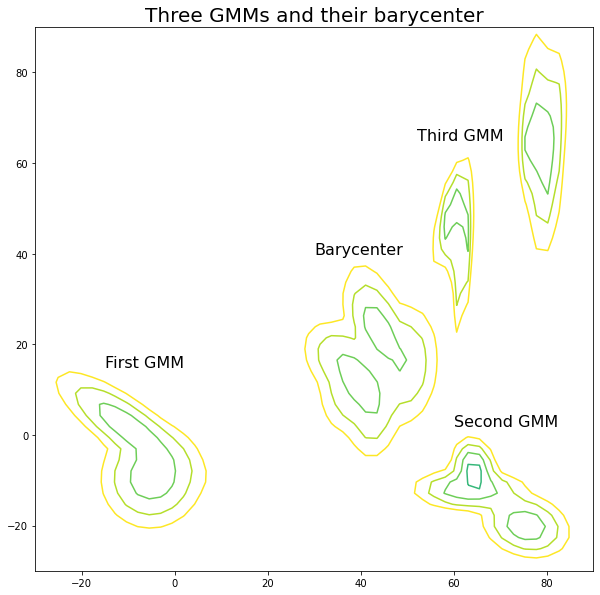

In [33]:
plt.figure(figsize=(10,10))

CS1 = plt.contour(
    x, y, n_log_prob[0, :, :], norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

CS2 = plt.contour(
    x, y, n_log_prob[1, :, :], norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

CS3 = plt.contour(
    x, y, n_log_prob[2, :, :], norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

CS4 = plt.contour(
    x, y, n_log_prob_bary, norm=LogNorm(vmin=1.0, vmax=10.0), levels=np.logspace(0, 1, 10)
)

plt.annotate('First GMM',(-15, 15), fontsize=16)
plt.annotate('Second GMM',(60, 2), fontsize=16)
plt.annotate('Third GMM',(52, 65), fontsize=16)
plt.annotate('Barycenter',(30, 40), fontsize=16)

plt.title("Three GMMs and their barycenter", fontsize=20)
plt.axis("tight")
plt.show()